In [2]:
# Load in Experimental data

#from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import lmfit

df = pd.read_excel(r"Kopie von Synthese _Einfluss Inhibitoren.xlsx", sheet_name="IPA-plotting" )
plt.rcParams["figure.dpi"] = 200
print(df.head())
time = df["Time in min"]
product = df["concentration metaraminol in mmol/L"]


   Time in min  concentration metaraminol in mmol/L
0          0.0                             0.000000
1         45.0                             2.120364
2         60.0                             3.425770
3         80.0                             4.481996
4        100.0                             5.213308


In [26]:
# calculate substrate concentration
# Concentration PAC = 20 mmol/L
# Concentration IPA = 125 mmol/L


substrate_PAC = np.subtract(20, product)
substrate_IPA = np.subtract(125, product)
print(time)


substrate_PAC_sliced = []
substrate_IPA_sliced = []
product_sliced = []
time_sliced = []
for i in range(6):
    substrate_PAC_sliced.append(substrate_PAC[i])
    substrate_IPA_sliced.append(substrate_IPA[i])
    time_sliced.append(time[i])
    product_sliced.append(product[i])

print(substrate_PAC_sliced, substrate_IPA_sliced, time_sliced)



print(substrate_PAC)
print(substrate_IPA)




0        0.0
1       45.0
2       60.0
3       80.0
4      100.0
5      120.0
6      159.6
7      180.0
8      300.0
9     1320.0
10    1440.0
Name: Time in min, dtype: float64
[20.0, 17.87963620380701, 16.57422997599486, 15.518003854346283, 14.78669236230855, 14.424924772627378] [125.0, 122.87963620380701, 121.57422997599485, 120.51800385434629, 119.78669236230854, 119.42492477262738] [0.0, 45.0, 60.0, 80.0, 100.0, 120.0]
0     20.000000
1     17.879636
2     16.574230
3     15.518004
4     14.786692
5     14.424925
6     13.773067
7     13.650675
8     12.824019
9      6.617507
10     6.156000
Name: concentration metaraminol in mmol/L, dtype: float64
0     125.000000
1     122.879636
2     121.574230
3     120.518004
4     119.786692
5     119.424925
6     118.773067
7     118.650675
8     117.824019
9     111.617507
10    111.156000
Name: concentration metaraminol in mmol/L, dtype: float64


0        0.0
1       45.0
2       60.0
3       80.0
4      100.0
5      120.0
6      159.6
7      180.0
8      300.0
9     1320.0
10    1440.0
Name: Time in min, dtype: float64


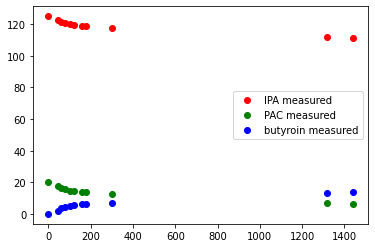

In [4]:
time = df["Time in min"]
product = df["concentration metaraminol in mmol/L"]

print(time)

fix, ax = plt.subplots()

ax.plot(time, substrate_IPA, label="IPA measured", color="red", linestyle="", marker="o")
ax.plot(time, substrate_PAC, label="PAC measured", color="green", linestyle="", marker="o")
ax.plot(time, product, label="butyroin measured", color="blue", linestyle="", marker="o")
ax.legend()

# Metaraminol synthesis 

In this notebook a model is created and fitted to the data resulting from a metaraminol synthesis reaction

<img src="./assets/reaction-schema-metaraminol.png" />

We have a reaction of the 2nd order with an excess of IPA, since only the concentration of Metaraminol can be measured, the other concentrations need to be calculated



[  0.  45.  60.  80. 100. 120.]
[[ 20.          17.8796362   16.57422998  15.51800385  14.78669236
   14.42492477]
 [125.         122.8796362  121.57422998 120.51800385 119.78669236
  119.42492477]
 [  0.           2.1203638    3.42577002   4.48199615   5.21330764
    5.57507523]]
y0_array [20, 125]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 12
    # variables        = 2
    chi-square         = 91836.1801
    reduced chi-square = 9183.61801
    Akaike info crit   = 111.314260
    Bayesian info crit = 112.284073
##  Warning: uncertainties could not be estimated:
    kB:  at initial value
    kB:  at boundary
[[Variables]]
    kA:  0.68992130 (init = 3)
    kB:  2.00000000 (init = 2)
None


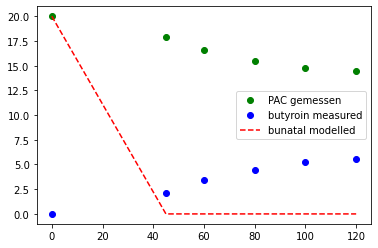

In [46]:
from scipy.integrate import odeint
import lmfit

# Definition of DGL system
# A = Initial conditions
# t = time or x-values
# kA = Constant A
# kB = Constant B
y0 = 20

reaction_time = np.array(time_sliced)

print(reaction_time)

data_list = [substrate_PAC_sliced, substrate_IPA_sliced, product_sliced]

data = np.array(data_list)

print(data)



y0_array = [20, 125]
print("y0_array", y0_array)



def dadt(kA, kB, A, B, t):
    #dcdt = -kA*A*kB*B
    dcdt = -(kA/(t+1))*A*B
    return dcdt
def dbdt(kA, kB, A, B, t):
    #dadt = kA*A*kB*B
    dadt = kA/(t+1)*(A**2)
    return dadt


def dglsys(init_cond_array, t, kA, kB):
    A = init_cond_array[0]
    B = init_cond_array[1]
    #C = init_cond_array[2]
    dAdt = dadt(kA,kB, A, B, t)
    dBdt = dbdt(kA,kB, A, B, t)
    #dBdt = (kA*A**2)*0.5 - kB*P - kC*P + kD*C
    #dBdt = dbdt(kA, kB, kC, kD, A, P, C, t)
    #dCdt = dcdt(kC, kD, P, C, t)
    #dCdt = kC*P - kD*C
    dZdt = np.array([dAdt, dBdt])
    return dZdt

sol = odeint(dglsys, y0_array, reaction_time, args=(0.689, 1))




params = lmfit.Parameters()
params.add('kA', 5, min=0.000000000000000000000001, max=3)
params.add("kB", 10, min=0.0000000002, max = 2)

def residual(params, time, data_sets):
    kA = params['kA'].value
    kB = params["kB"].value
    
    ymodel=odeint(dglsys, y0_array, time, args=(kA, kB))
    prod = data_sets[0]-ymodel[:,0] # array 1
    substr = data_sets[2]-ymodel[:,1]
    result = [prod, substr] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(np.array(reaction_time), data_list))
print(lmfit.report_fit(solution))



fig, ax = plt.subplots()
ax.plot(reaction_time, substrate_PAC_sliced, label="PAC gemessen", color="green", linestyle="", marker="o")
ax.plot(reaction_time, product_sliced, label="butyroin measured", color="blue", linestyle="", marker="o")
#ax.plot(time, product2, label="octandiol modelled", color="green", linestyle="", marker="o")

#ax.plot(time, sol[:,2], label="octandiol modelled", linestyle="--", color="green")
ax.plot(reaction_time, sol[:,0], label="bunatal modelled", linestyle="--", color="red")
#ax.plot(time, sol[:,1], label="butyroin modelled", linestyle="--", color = "blue")


ax.legend()
#plt.savefig("testfig-delayed-only measured.svg", format="svg")
plt.show()




In [6]:
# Extenden Model


time_reduced = [155, 170, 203, 440, 1440]
substrate_extended = np.array(substrate[5:])
product_extended = np.array(product[5:])
product2_extended = np.array(product2[5:])
data_list_extended = [substrate_extended, product_extended, product2_extended]
data_extended = np.array(data_list_reduced)

print(data_list_extended)

'''

def dglsys(init_cond_array, t, kA, kB):
    A = init_cond_array[0]
    P = init_cond_array[1]
    dAdt = -kA*A**2 + kB*P
    dBdt = (kA*A**2)*0.5 - kB*P
    dZdt = np.array([dAdt, dBdt])
    return dZdt

sol = odeint(dglsys, init_cond_reduced, time_reduced, args=(0.000245, 0.0024))

fig, ax = plt.subplots()
ax.plot(time_reduced, substrate_reduced, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time_reduced, product_reduced, label="butyroin measured", color="blue", linestyle="", marker="o")

params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)

def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    
    ymodel = odeint(dglsys, init_cond_reduced, time_reduced, args=(kA, kP))
    substr_red = data_reduced[0]-ymodel[:,0] # array 1
    product_red = data_reduced[1]-ymodel[:,1] # array 2
    result = [substr_red, product_red] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(time_reduced, data_reduced))
print(lmfit.report_fit(solution))


ax.plot(time_reduced, sol[:,0], label="bunatal modelled", linestyle="--", color="red")
ax.plot(time_reduced, sol[:,1], label="butyroin modelled", linestyle="--", color = "blue")


print(time_reduced)
print(substrate_reduced)
print(product_reduced)

'''

NameError: name 'substrate' is not defined

[[235.40306997 136.66700304  78.77557135  39.50173584  15.37370005
   15.13829237  14.49406891  13.84240584  12.42792802   9.91667821]
 [  0.          35.13576358  59.77367168  80.61084579  85.41664722
   78.41427103  72.13699274  67.0658672   57.60108041  50.92454335]
 [  0.           0.           0.           0.           0.
    6.78494113  11.32583558  17.78875041  30.07338747  36.26918197]]
[240, 0, 0]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 96
    # data points      = 30
    # variables        = 5
    chi-square         = 3730.83814
    reduced chi-square = 149.233525
    Akaike info crit   = 154.695724
    Bayesian info crit = 161.701711
[[Variables]]
    kA:   2.6850e-04 +/- 3.1903e-05 (11.88%) (init = 2)
    kP:   0.00109254 +/- 3.8332e-04 (35.09%) (init = 2)
    kC:   1.71596831 +/- 3.88285002 (226.28%) (init = 2)
    kD:   0.51954958 +/- 0.72761890 (140.05%) (init = 2)
    lag:  0.06955476 +/- 0.08004113 (115.08%) (init = 2)
[[Correlations

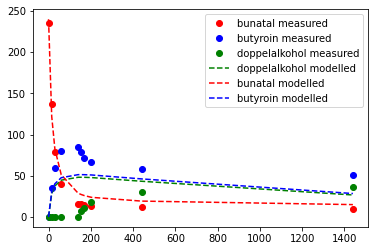

In [ ]:

data_list = [substrate, product, product2]

data = np.array(data_list)

print(data)


y0_array = [240, 0, 0]
print(y0_array)

def dglsys(init_cond_array, t, kA, kB, kC, kD, lag):
    A = init_cond_array[0]
    P = init_cond_array[1]
    C = init_cond_array[2]
    dAdt = -kA*A**2 + kB*P
    dBdt = (kA*A**2)*0.5 - kB*P - lag*kC*P + kD*C
    dCdt = lag*kC*P - kD*C
    dZdt = np.array([dAdt, dBdt, dCdt])
    return dZdt

sol = odeint(dglsys, y0_array, time, args=(0.00027, 0.002, 0.68, 2.9, 4))



params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)
params.add('kC', 2, min=0.0000000001, max=3)
params.add('kD', 2, min=0.0000000001, max=3)
params.add('lag', 2, min=0.0001, max=10)

def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    kC = params['kC'].value
    kD = params['kD'].value
    lag = params['lag'].value
    
    ymodel=odeint(dglsys, y0_array, time, args=(kA, kP, kC, kD, lag))
    substr = data_sets[0]-ymodel[:,0] # array 1
    product = data_sets[1]-ymodel[:,1] # array 2
    product2 = data_sets[2]-ymodel[:,2]
    result = [substr, product, product2] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(np.array(time), data))
print(lmfit.report_fit(solution))


fig, ax = plt.subplots()
ax.plot(time, substrate, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time, product, label="butyroin measured", color="blue", linestyle="", marker="o")
ax.plot(time, product2, label="doppelalkohol measured", color="green", linestyle="", marker="o")

ax.plot(time, sol[:,2], label="doppelalkohol modelled", linestyle="--", color="green")
ax.plot(time, sol[:,0], label="bunatal modelled", linestyle="--", color="red")
ax.plot(time, sol[:,1], label="butyroin modelled", linestyle="--", color = "blue")


ax.legend()
plt.savefig("testfig.svg", format="svg")

[[235.40306997 136.66700304  78.77557135  39.50173584  15.37370005
   15.13829237  14.49406891  13.84240584  12.42792802   9.91667821]
 [  0.          35.13576358  59.77367168  80.61084579  85.41664722
   78.41427103  72.13699274  67.0658672   57.60108041  50.92454335]
 [  0.           0.           0.           0.           0.
    6.78494113  11.32583558  17.78875041  30.07338747  36.26918197]]
[240, 0, 0]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 71
    # data points      = 30
    # variables        = 4
    chi-square         = 2614.33590
    reduced chi-square = 100.551381
    Akaike info crit   = 142.027040
    Bayesian info crit = 147.631830
[[Variables]]
    kA:  2.4595e-04 +/- 2.3019e-05 (9.36%) (init = 2)
    kP:  8.7198e-04 +/- 2.9530e-04 (33.87%) (init = 2)
    kC:  0.00867379 +/- 0.00312970 (36.08%) (init = 2)
    kD:  0.01453795 +/- 0.00695481 (47.84%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(kC, kD) = 0.882
 

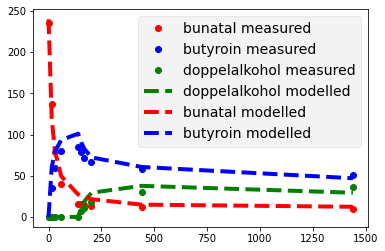

In [ ]:
# Definition of DGL system
# A = Initial conditions
# t = time or x-values
# kA = Constant A
# kB = Constant B
y0 = 100



data_list = [substrate, product, product2]

data = np.array(data_list)

print(data)


y0_array = [240, 0, 0]
print(y0_array)


def dbdt(kA, kB, kC, kD, A,P, C, t):
    if t <= 140:
        dbdt = (kA*A**2)*0.5 - kB*P
        return dbdt
    elif t >= 140:
        dbdt = (kA*A**2)*0.5 - kB*P - kC*P + kD*C
        return dbdt
def dcdt(kC, kD, P, C, t):
    if t <= 140:
        return 0
    elif t >= 140:
        dcdt = kC*P - kD*C
        return dcdt



def dglsys(init_cond_array, t, kA, kB, kC, kD):
    A = init_cond_array[0]
    P = init_cond_array[1]
    C = init_cond_array[2]
    dAdt = -kA*A**2 + kB*P
    #dBdt = (kA*A**2)*0.5 - kB*P - kC*P + kD*C
    dBdt = dbdt(kA, kB, kC, kD, A, P, C, t)
    dCdt = dcdt(kC, kD, P, C, t)
    #dCdt = kC*P - kD*C
    dZdt = np.array([dAdt, dBdt, dCdt])
    return dZdt

sol = odeint(dglsys, y0_array, time, args=(0.00028, 0.000872, 0.0086, 0.014))



params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)
params.add('kC', 2, min=0.0000000001, max=3)
params.add('kD', 2, min=0.0000000001, max=3)

def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    kC = params['kC'].value
    kD = params['kD'].value
    
    ymodel=odeint(dglsys, y0_array, time, args=(kA, kP, kC, kD))
    substr = data_sets[0]-ymodel[:,0] # array 1
    product = data_sets[1]-ymodel[:,1] # array 2
    product2 = data_sets[2]-ymodel[:,2]
    result = [substr, product, product2] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(np.array(time), data))
print(lmfit.report_fit(solution))


fig, ax = plt.subplots()
ax.plot(time, substrate, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time, product, label="butyroin measured", color="blue", linestyle="", marker="o")
ax.plot(time, product2, label="doppelalkohol measured", color="green", linestyle="", marker="o")

ax.plot(time, sol[:,2], label="doppelalkohol modelled", linestyle="--", color="green")
ax.plot(time, sol[:,0], label="bunatal modelled", linestyle="--", color="red")
ax.plot(time, sol[:,1], label="butyroin modelled", linestyle="--", color = "blue")


ax.legend()
plt.savefig("testfig-delayed.svg", format="svg")
plt.show()